In [1]:
import numpy as np
import pandas as pd
import math
import sys

import matplotlib.pyplot as plt 
%matplotlib inline

import random as rand
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

from subset_pca import *



from time import time

In [2]:
adult_test_df = pd.read_csv('datasets/benchmark/adult_clean_test.csv')
adult_train_df = pd.read_csv('datasets/benchmark/adult_clean_train.csv')
titanic_test_df = pd.read_csv('datasets/benchmark/titanic_clean_test.csv')
titanic_train_df = pd.read_csv('datasets/benchmark/titanic_clean_train.csv')
weather_test_df = pd.read_csv('datasets/benchmark/weatherAUS_clean_test.csv')
weather_train_df = pd.read_csv('datasets/benchmark/weatherAUS_clean_train.csv')
wine_test_df = pd.read_csv('datasets/benchmark/wine_test.csv')
wine_train_df = pd.read_csv('datasets/benchmark/wine_train.csv')

In [3]:
def extract_X_y(df, col_y):
    X = df.drop(col_y, axis=1)
    y = df[col_y]
    return X, y

In [4]:
adult_test_X, adult_test_y = extract_X_y(adult_test_df, 'income_>50k')
adult_train_X, adult_train_y = extract_X_y(adult_train_df, 'income_>50k')

titanic_test_X, titanic_test_y = extract_X_y(titanic_test_df, 'Survived')
titanic_train_X, titanic_train_y = extract_X_y(titanic_train_df, 'Survived')

weather_test_X, weather_test_y = extract_X_y(weather_test_df, 'RainTomorrow')
weather_train_X, weather_train_y = extract_X_y(weather_train_df, 'RainTomorrow')

wine_test_X, wine_test_y = extract_X_y(wine_test_df, 'quality')
wine_train_X, wine_train_y = extract_X_y(wine_train_df, 'quality')

In [5]:
def df_features_to_dicts(df):
    columns = df.columns
    dicts = []
   
    for index, row in df.iterrows():
        feature_dict = {}
        for col in columns:
            feature_dict[col] = row[col]
        dicts.append(feature_dict)
    return dicts

In [6]:
adult_test_dict_X = df_features_to_dicts(adult_test_X)
adult_train_dict_X = df_features_to_dicts(adult_train_X)

titanic_test_dict_X = df_features_to_dicts(titanic_test_X)
titanic_train_dict_X = df_features_to_dicts(titanic_train_X)

weather_test_dict_X = df_features_to_dicts(weather_test_X)
weather_train_dict_X = df_features_to_dicts(weather_train_X)

wine_test_dict_X = df_features_to_dicts(wine_test_X)
wine_train_dict_X = df_features_to_dicts(wine_train_X)

In [7]:
titanic_train_X.shape

(1047, 20)

In [8]:
titanic_train_y.shape

(1047,)

In [9]:
len(titanic_train_dict_X)

1047

In [10]:
def compute_score(model, test_X, test_y):
    pred = model.predict(test_X)
    acc = accuracy_score(pred, test_y)
    f1 = f1_score(pred, test_y)
    conf = confusion_matrix(pred, test_y)

    return acc, f1, conf

In [11]:
def fit_compute_score(model, train_X, train_y, test_X, test_y):
    t0 = time()
    model.fit(train_X, train_y)
    duration = time() - t0
    train_acc, train_f1, train_conf = compute_score(model, train_X, train_y)
    test_acc, test_f1, test_conf = compute_score(model, test_X, test_y)
    print("duration", duration)
    print("train accuracy", train_acc)
    print("train f1", train_f1)
    print("train tn, fp, fn, tp", train_conf.ravel()) 
    print("test accuracy", test_acc)
    print("test f1", test_f1)
    print("test tn, fp, fn, tp", test_conf.ravel())
    print()
    
    return train_acc, train_f1, train_conf, test_acc, test_f1, test_conf

In [12]:
def compare_feature_hashing(train_X, train_dict_X, train_y, test_X, test_dict_X, test_y):
    clf_ridge_default = RidgeClassifier()
    print('ridge_default')
    ridge_default_train_acc, ridge_default_train_f1, ridge_default_train_conf, \
        ridge_default_test_acc, ridge_default_test_f1, ridge_default_test_conf = \
        fit_compute_score(clf_ridge_default, train_X, train_y, test_X, test_y)

    n_estimators = 1000
    clf_randfor_default = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators)
    print('randfor_default')
    randfor_default_train_acc, randfor_default_train_f1, randfor_default_train_conf, \
        randfor_default_test_acc, randfor_default_test_f1, randfor_default_test_conf = \
        fit_compute_score(clf_randfor_default, train_X, train_y, test_X, test_y)

    ridge_train_acc = []
    ridge_train_f1 = []
    ridge_train_conf = []
    ridge_test_acc = []
    ridge_test_f1 = []
    ridge_test_conf = []
    randfor_train_acc = []
    randfor_train_f1 = []
    randfor_train_conf = []
    randfor_test_acc = []
    randfor_test_f1 = []
    randfor_test_conf = []
    
    n, d = train_X.shape
    for i in range(2, 11, 2):
        percent = 0.1*i
        n_features = math.ceil(train_X.shape[1]*percent)
        print("percent", percent, "n_features", n_features)
        pca = SubsetPCA(value=n_features, type='dim')
        # hasher = FeatureHasher(n_features=n_features)
        train_X_small = pca.fit_transform(train_X)
        test_X_small = pca.transform(test_X)
        
        print()

        clf_ridge_small = RidgeClassifier()
        print('ridge_compressed')
        ridge_small_train_acc, ridge_small_train_f1, ridge_small_train_conf, \
            ridge_small_test_acc, ridge_small_test_f1, ridge_small_test_conf = \
            fit_compute_score(clf_ridge_small, train_X_small, train_y, test_X_small, test_y)
        ridge_train_acc.append(ridge_small_train_acc)
        ridge_train_f1.append(ridge_small_train_f1)
        ridge_train_conf.append(ridge_small_train_conf)
        ridge_test_acc.append(ridge_small_test_acc)
        ridge_test_f1.append(ridge_small_test_f1)
        ridge_test_conf.append(ridge_small_test_conf)

        clf_randfor_small = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators)
        print('randfor_compressed')
        randfor_small_train_acc, randfor_small_train_f1, randfor_small_train_conf, \
            randfor_small_test_acc, randfor_small_test_f1, randfor_small_test_conf = \
            fit_compute_score(clf_randfor_small, train_X_small, train_y, test_X_small, test_y)
        randfor_train_acc.append(randfor_small_train_acc)
        randfor_train_f1.append(randfor_small_train_f1)
        randfor_train_conf.append(randfor_small_train_conf)
        randfor_test_acc.append(randfor_small_test_acc)
        randfor_test_f1.append(randfor_small_test_f1)
        randfor_test_conf.append(randfor_small_test_conf)

    fig, ax = plt.subplots(2, 2, figsize=(15,10), tight_layout=True)
    
    t = np.ceil(np.arange(2, 11, 2) * 0.1 * train_X.shape[1])
    
    ax[0,0].plot(t, ridge_default_train_acc*np.ones(len(t)), label='ridge_default')
    ax[0,0].plot(t, randfor_default_train_acc*np.ones(len(t)), label='randfor_default')
    ax[0,0].plot(t, ridge_train_acc, label='ridge_compressed')
    ax[0,0].plot(t, randfor_train_acc, label='randfor_compressed')
    ax[0,0].set(xlabel='features', ylabel='accuracy', title='train')
    ax[0,0].legend()

    ax[0,1].plot(t, ridge_default_test_acc*np.ones(len(t)), label='ridge_default')
    ax[0,1].plot(t, randfor_default_test_acc*np.ones(len(t)), label='randfor_default')
    ax[0,1].plot(t, ridge_test_acc, label='ridge_compressed')
    ax[0,1].plot(t, randfor_test_acc, label='randfor_compressed')
    ax[0,1].set(xlabel='features', ylabel='accuracy', title='test')
    ax[0,1].legend()
    
    ax[1,0].plot(t, ridge_default_train_f1*np.ones(len(t)), label='ridge_default')
    ax[1,0].plot(t, randfor_default_train_f1*np.ones(len(t)), label='randfor_default')
    ax[1,0].plot(t, ridge_train_f1, label='ridge_compressed')
    ax[1,0].plot(t, randfor_train_f1, label='randfor_compressed')
    ax[1,0].set(xlabel='features', ylabel='f1', title='train')
    ax[1,0].legend()
    
    ax[1,1].plot(t, ridge_default_test_f1*np.ones(len(t)), label='ridge_default')
    ax[1,1].plot(t, randfor_default_test_f1*np.ones(len(t)), label='randfor_default')
    ax[1,1].plot(t, ridge_test_f1, label='ridge_compressed')
    ax[1,1].plot(t, randfor_test_f1, label='randfor_compressed')
    ax[1,1].set(xlabel='features', ylabel='f1', title='test')
    ax[1,1].legend()

    plt.show()

ridge_default
duration 0.11497354507446289
train accuracy 0.8433445089959819
train f1 0.6108462076419353
train tn, fp, fn, tp [28148  4476  1645  4804]
test accuracy 0.8356024158050978
test f1 0.6044334975369458
test tn, fp, fn, tp [6936 1180  426 1227]

randfor_default
duration 11.974145889282227
train accuracy 0.9999488137588616
train f1 0.9998922413793103
train tn, fp, fn, tp [29792     1     1  9279]
test accuracy 0.8563824342307299
test f1 0.6798996121378053
test tn, fp, fn, tp [6876  917  486 1490]

percent 0.2 n_features 19


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var



ridge_compressed
duration 0.11701083183288574
train accuracy 0.7729890205512758
train f1 0.16241737488196414
train tn, fp, fn, tp [29343  8420   450   860]
test accuracy 0.7625140751356331
test f1 0.14705882352941177
test tn, fp, fn, tp [7249 2207  113  200]

randfor_compressed
duration 24.851584911346436
train accuracy 0.9347631356691322
train f1 0.8531935725393077
train tn, fp, fn, tp [29117  1873   676  7407]
test accuracy 0.7081584604360733
test f1 0.3600448933782267
test tn, fp, fn, tp [6116 1605 1246  802]

percent 0.4 n_features 37


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var



ridge_compressed
duration 0.23299932479858398
train accuracy 0.7807181429631715
train f1 0.2173913043478261
train tn, fp, fn, tp [29315  8090   478  1190]
test accuracy 0.771726891186406
test f1 0.21368124118476725
test tn, fp, fn, tp [7236 2104  126  303]

randfor_compressed
duration 16.347565412521362
train accuracy 0.9999488137588616
train f1 0.9998922297661386
train tn, fp, fn, tp [29793     2     0  9278]
test accuracy 0.8076568737844201
test f1 0.5291906790278126
test tn, fp, fn, tp [6834 1351  528 1056]

percent 0.6000000000000001 n_features 56


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var



ridge_compressed
duration 0.3040013313293457
train accuracy 0.8055178767947175
train f1 0.4131593173218009
train tn, fp, fn, tp [28799  6605   994  2675]
test accuracy 0.795577848295629
test f1 0.3979499547784142
test tn, fp, fn, tp [7112 1747  250  660]

randfor_compressed
duration 17.479580640792847
train accuracy 0.9999488137588616
train f1 0.9998922413793103
train tn, fp, fn, tp [29792     1     1  9279]
test accuracy 0.8287439860784113
test f1 0.5948171470089609
test tn, fp, fn, tp [6868 1179  494 1228]

percent 0.8 n_features 74


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var



ridge_compressed
duration 0.28600072860717773
train accuracy 0.8229979781434751
train f1 0.5138478841557711
train tn, fp, fn, tp [28502  5625  1291  3655]
test accuracy 0.8153342204933974
test f1 0.5060240963855422
test tn, fp, fn, tp [7041 1483  321  924]

randfor_compressed
duration 13.269155025482178
train accuracy 0.9999488137588616
train f1 0.9998922413793103
train tn, fp, fn, tp [29792     1     1  9279]
test accuracy 0.8432797625140751
test f1 0.6417037210390827
test tn, fp, fn, tp [6867 1036  495 1371]

percent 1.0 n_features 92


C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\ProgramData\Anaconda3\envs\env_3_6\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var



ridge_compressed
duration 0.44210124015808105
train accuracy 0.8433445089959819
train f1 0.6108462076419353
train tn, fp, fn, tp [28148  4476  1645  4804]
test accuracy 0.8356024158050978
test f1 0.6044334975369458
test tn, fp, fn, tp [6936 1180  426 1227]

randfor_compressed
duration 16.35258436203003
train accuracy 0.9999488137588616
train f1 0.9998922413793103
train tn, fp, fn, tp [29792     1     1  9279]
test accuracy 0.8569966219674481
test f1 0.681704260651629
test tn, fp, fn, tp [6876  911  486 1496]



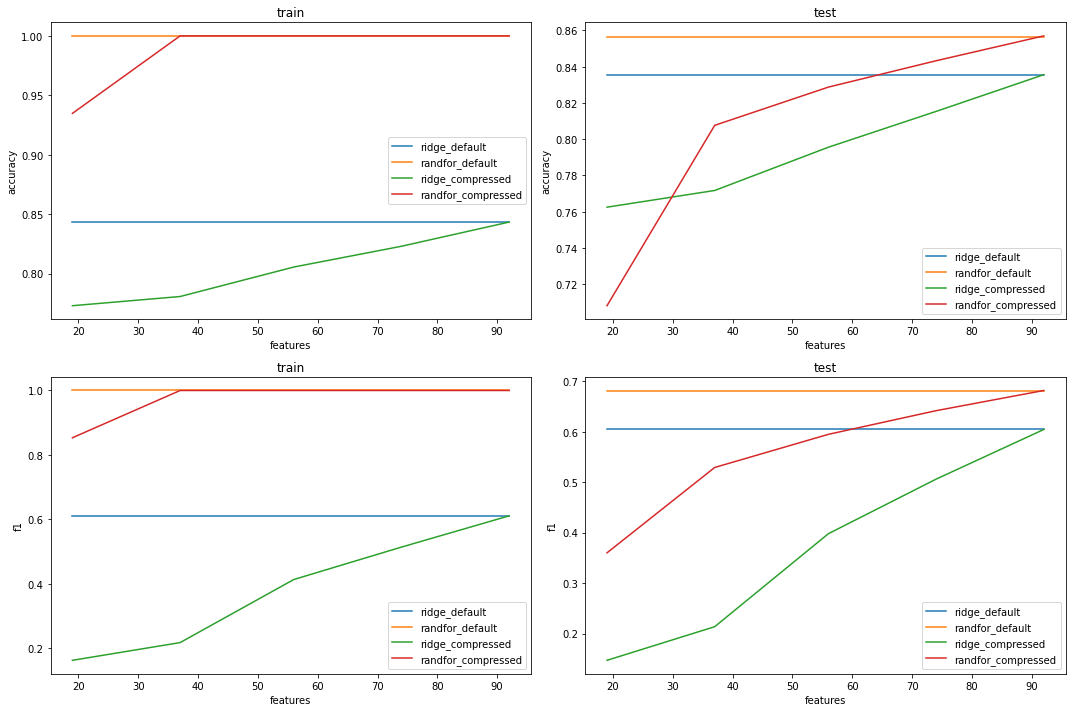

In [13]:
compare_feature_hashing(adult_train_X, adult_train_dict_X, adult_train_y, adult_test_X, adult_test_dict_X, adult_test_y)

ridge_default
duration 0.12200021743774414
train accuracy 0.8538681948424068
train f1 0.7994757536041939
train tn, fp, fn, tp [589  83  70 305]
test accuracy 0.8664122137404581
test f1 0.8223350253807108
test tn, fp, fn, tp [146  25  10  81]

randfor_default
duration 3.321998357772827
train accuracy 0.9808978032473734
train f1 0.974025974025974
train tn, fp, fn, tp [652  13   7 375]
test accuracy 0.8244274809160306
test f1 0.7628865979381443
test tn, fp, fn, tp [142  32  14  74]

percent 0.2 n_features 4

ridge_compressed
duration 0.14600205421447754
train accuracy 0.6475644699140402
train f1 0.21987315010570824
train tn, fp, fn, tp [626 336  33  52]
test accuracy 0.6145038167938931
test f1 0.20472440944881892
test tn, fp, fn, tp [148  93   8  13]

randfor_compressed
duration 3.3780925273895264
train accuracy 0.9808978032473734
train f1 0.9739583333333334
train tn, fp, fn, tp [653  14   6 374]
test accuracy 0.7442748091603053
test f1 0.6794258373205743
test tn, fp, fn, tp [124  35  32 

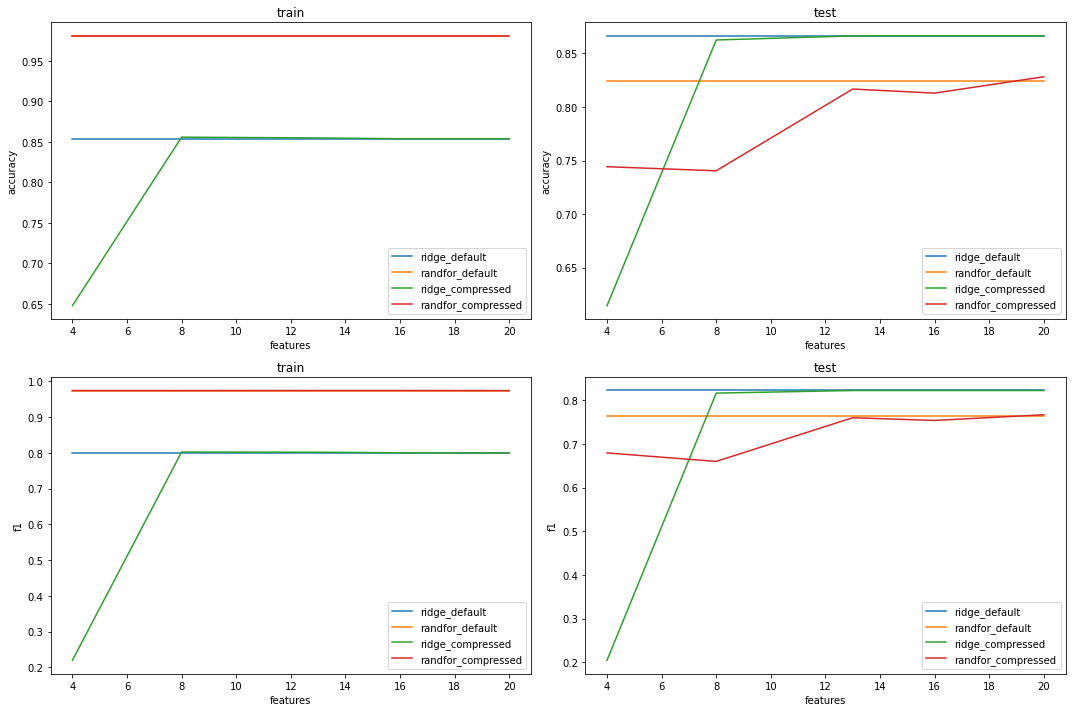

In [14]:
compare_feature_hashing(titanic_train_X, titanic_train_dict_X, titanic_train_y, titanic_test_X, titanic_test_dict_X, titanic_test_y)

ridge_default
duration 0.019002676010131836
train accuracy 0.7864375
train f1 0.7818704117459304
train tn, fp, fn, tp [6459 1878 1539 6124]
test accuracy 0.78525
test f1 0.7792341300436905
test tn, fp, fn, tp [1625  482  377 1516]

randfor_default
duration 4.991552829742432
train accuracy 1.0
train f1 1.0
train tn, fp, fn, tp [7998    0    0 8002]
test accuracy 0.809
test f1 0.8094763092269326
test tn, fp, fn, tp [1613  375  389 1623]

percent 0.2 n_features 6

ridge_compressed
duration 0.010997533798217773
train accuracy 0.756
train f1 0.7555416405760803
train tn, fp, fn, tp [6063 1969 1935 6033]
test accuracy 0.747
test f1 0.7411764705882353
test tn, fp, fn, tp [1539  549  463 1449]

randfor_compressed
duration 5.05400276184082
train accuracy 1.0
train f1 1.0
train tn, fp, fn, tp [7998    0    0 8002]
test accuracy 0.77175
test f1 0.7666751852798365
test tn, fp, fn, tp [1587  498  415 1500]

percent 0.4 n_features 12

ridge_compressed
duration 0.026997089385986328
train accuracy 0.77

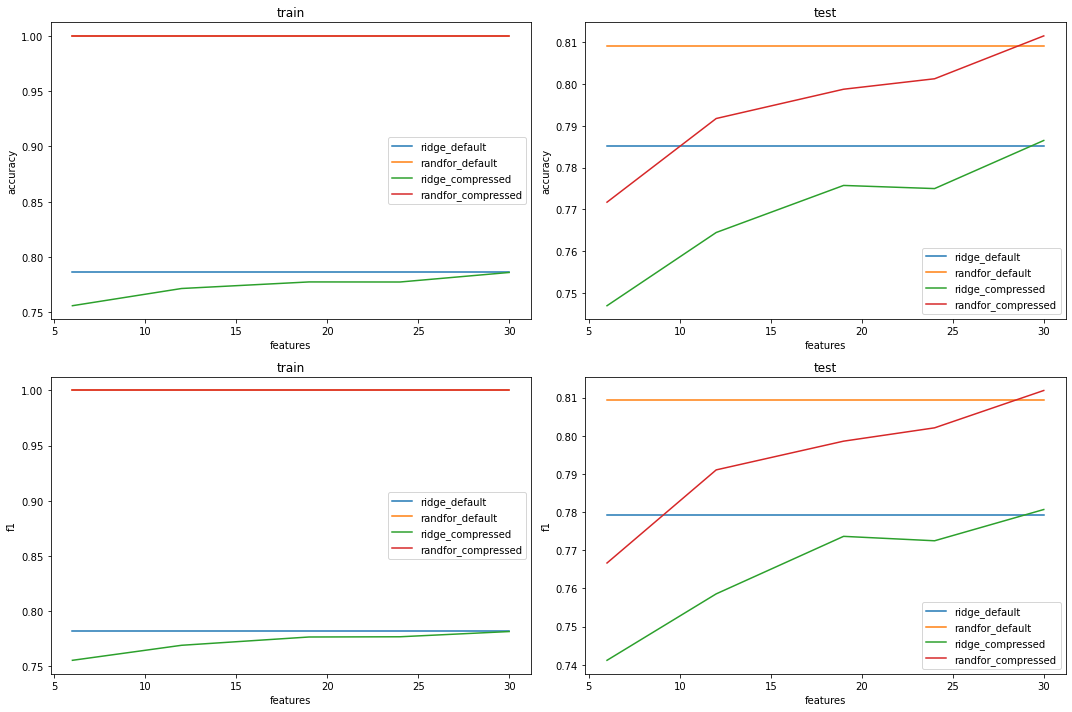

In [15]:
compare_feature_hashing(weather_train_X, weather_train_dict_X, weather_train_y, weather_test_X, weather_test_dict_X, weather_test_y)

ridge_default
duration 0.020997047424316406
train accuracy 0.7490226739640344
train f1 0.7602688573562361
train tn, fp, fn, tp [449 174 147 509]
test accuracy 0.740625
test f1 0.7446153846153846
test tn, fp, fn, tp [116  51  32 121]

randfor_default
duration 3.1840009689331055
train accuracy 1.0
train f1 1.0
train tn, fp, fn, tp [596   0   0 683]
test accuracy 0.81875
test f1 0.8253012048192772
test tn, fp, fn, tp [125  35  23 137]

percent 0.2 n_features 3

ridge_compressed
duration 0.06699442863464355
train accuracy 0.6497263487099296
train f1 0.702523240371846
train tn, fp, fn, tp [302 154 294 529]
test accuracy 0.6625
test f1 0.7157894736842104
test tn, fp, fn, tp [ 76  36  72 136]

randfor_compressed
duration 2.8959991931915283
train accuracy 1.0
train f1 1.0
train tn, fp, fn, tp [596   0   0 683]
test accuracy 0.7875
test f1 0.8034682080924855
test tn, fp, fn, tp [113  33  35 139]

percent 0.4 n_features 5

ridge_compressed
duration 0.004000663757324219
train accuracy 0.670054730

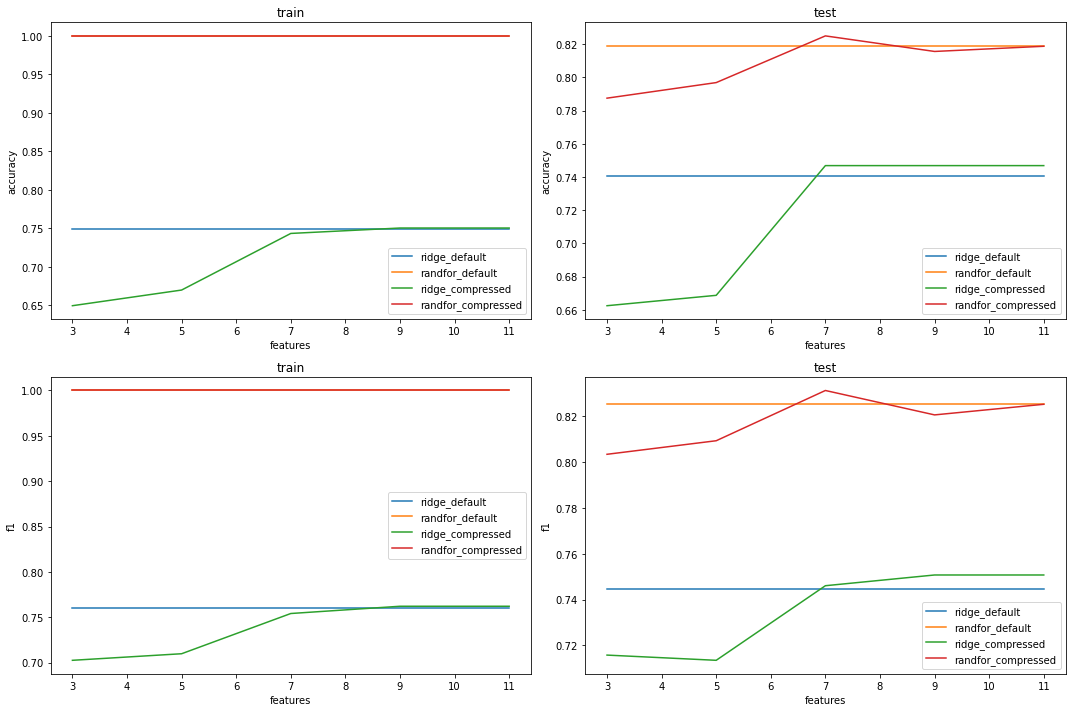

In [16]:
compare_feature_hashing(wine_train_X, wine_train_dict_X, wine_train_y, wine_test_X, wine_test_dict_X, wine_test_y)